In [87]:
import numpy as np
import json
import pandas as pd

# Load the data
with open('property_data.json', 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the first few rows
df.head()

# Create static identifier so we can matchup results later
df['identifier'] = range(1, len(df) + 1)

# Create copy of the of our unsold houses with identifier saved
df_target = df[df['is_sold'] == False].copy() 

# Show house type ratios before OHE
house_type_counts = df['house_type'].value_counts()
# Calculate the total number of houses
total_houses = len(df)

# Calculate the percentage of each house type
house_type_percentages = (house_type_counts / total_houses) * 100

# Create a DataFrame to display the counts and percentages
#house_type_distribution = pd.DataFrame({'Count': house_type_counts, 'Percentage': house_type_percentages})

# Display the distribution
#print("House Type Distribution:")
#print(house_type_distribution)

# Drop "Over 55s" and "Off The Plan" house types
#df = df[df['house_type'] != 'Over 55s']
#df = df[df['house_type'] != 'Off The Plan']

# Merge "Unit" and "Apartment" into a single category
#df['house_type'] = df['house_type'].replace(['Unit', 'Apartment', 'Duplex'], 'Unit/Apartment/Duplex')

# Merge "Villa" and "Townhouse" into a single category
#df['house_type'] = df['house_type'].replace(['Villa', 'Townhouse'], 'Villa/Townhouse')

# Perform one-hot encoding on the updated house_type column
df = pd.get_dummies(df, columns=['house_type'], prefix='house_type')

# Remove rows where landsize is greater than 10,000
df = df[df['landsize'] <= 10000]

# Remove rows where local_community_population is zero (aka no ABS data)
df = df[df['local_community_population'] != 0]

# Function to add noise to prices
def add_noise_to_prices(prices, noise_level=0.05):
    noise = np.random.uniform(-noise_level, noise_level, prices.shape)
    return prices * (1 + noise)

# Create a ratio for crime against people vs. property
df['crime_ratio'] = np.where((df['apn_crime'] != 0) & (df['ap_crime'] != 0), df['ap_crime'] / df['apn_crime'], 0)

# Summarize total crime
df['crime_per_capita'] = (df['ap_crime'] + df['apn_crime']) / df['people']

# Create affordability ratio for mortages
df['affordability_ratio'] = df['median_monthly_mortgage_repayment'] / df['median_weekly_household_income']

# Convert local_dining and local_shop to per capita values
df['dining_per_capita'] = df['local_dining'] / df['local_community_population']
df['shop_per_capita'] = df['local_shop'] / df['local_community_population']

# Add noise to prices in the sold houses dataset
df['price'] = add_noise_to_prices(df['price'])

# Transform price (target) logarithmically
df['price'] = np.log(df['price'])
df['landsize'] = np.log(df['landsize'])

# Apply logarithmic transformation to columns starting with 'nearest_' and 'distance_to_perth_cbd'
nearest_columns = [col for col in df.columns if col.startswith('nearest_')]
for col in nearest_columns + ['distance_to_perth_cbd']:
    df[f'log_{col}'] = np.log(df[col] + 1)
    df = df.drop(columns=[col])

# Apply logarithmic transformation to median_monthly_mortgage_repayment, dining_per_capita, and shop_per_capita
df['log_median_monthly_mortgage_repayment'] = np.log(df['median_monthly_mortgage_repayment'] + 1)
df['log_dining_per_capita'] = np.log(df['dining_per_capita'] + 1)
df['log_shop_per_capita'] = np.log(df['shop_per_capita'] + 1)
df = df.drop(columns=['median_monthly_mortgage_repayment', 'dining_per_capita', 'shop_per_capita'])

# Rename columns starting with "log_" to remove the prefix
df.columns = [col[4:] if col.startswith('log_') else col for col in df.columns]

# Drop local data that is not well collected
columns_to_drop = ['local_waste_facility', 'local_sports_facility', 'local_leisure_facility',
                   'local_public_art', 'local_swimming_pool', 'local_garden', 'local_social_facility']
df = df.drop(columns=columns_to_drop)

# Drop the 'suburb' column
df = df.drop(columns=['ap_crime'])
df = df.drop(columns=['apn_crime'])

# Drop local dining/shops
df = df.drop(columns=['local_dining'])
df = df.drop(columns=['local_shop'])

# Drop redundant suburb level data we already collected
df = df.drop(columns=['people', 'houses'])

# Drop female ratio (we have male ratio)
df = df.drop(columns=['female_ratio'])

# Drop families/child_per_household (captured by local community values)
df = df.drop(columns=['families', 'child_per_household'])

# Drop median rent (captured by mortgage repayments)
df = df.drop(columns=['median_weekly_rent'])

# Drop offence data that we have already aggregated (apn/ap)
offense_columns = [col for col in df.columns if col.startswith('offences')]
df = df.drop(columns=offense_columns)

# Drop 'local_community_dwellings'
df = df.drop(columns=['local_community_dwellings'])

# Drop 'median_weekly_household_income'
df = df.drop(columns=['median_weekly_household_income'])

# Drop 'distance_to_perth_airport' (captured by CBD distance)
df = df.drop(columns=['distance_to_perth_airport'])

# Drop the local_tourism column
df = df.drop(columns=['local_tourism'])

# Drop text-based fields except 'house_type'
text_fields = ['address', 'image_url', 'details_url', 'suburb']
df = df.drop(columns=text_fields)

# Find the minimum latitude and longitude values
min_latitude = df['latitude'].min()
min_longitude = df['longitude'].min()

# Subtract the minimum values from latitude and longitude
df['latitude'] = df['latitude'] - min_latitude
df['longitude'] = df['longitude'] - min_longitude

# Remove outliers for bedrooms, bathrooms, and parking
df = df[(df['bedrooms'] <= 5) & (df['bathrooms'] <= 4) & (df['parking'] <= 5)]

# Suppress outliers using winsorization
columns_to_winsorize = ['apn_crime_inc', 'ap_crime_inc', 'crime_ratio', 'crime_per_capita', 'affordability_ratio']
for col in columns_to_winsorize:
    lower_percentile = df[col].quantile(0.05)
    upper_percentile = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=lower_percentile, upper=upper_percentile)

# Print data types and filled missing values
missing_values_after = df.isnull().sum()
print("Missing Values After Filling:\n", missing_values_after)

# Convert one hot encoded to bool for PyTorch.
bool_columns = ['house_type_House', 'house_type_Land', 'house_type_Unit/Apartment/Duplex', 'house_type_Villa/Townhouse']
df[bool_columns] = df[bool_columns].astype(int)

# Set pandas display option to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Descriptive statistics
desc_stats = df.describe()

# Function to display descriptive statistics in chunks
def display_desc_stats(desc_stats, chunk_size=8):
    for i in range(0, len(desc_stats.columns), chunk_size):
        print(desc_stats.iloc[:, i:i+chunk_size])
        print("\n")

# Display descriptive statistics in chunks of 8 columns
display_desc_stats(desc_stats)

# Print top few rows again to visualize one hot encoding
df.head()



House Type Distribution:
               Count  Percentage
house_type                      
House         144956       81.16
Land           14948        8.37
Apartment       5845        3.27
Villa           4657        2.61
Unit            3921        2.20
Townhouse       2848        1.59
Duplex          1314        0.74
Over 55s          94        0.05
Off The Plan      20        0.01
Missing Values After Filling:
 price                                0
landsize                             0
latitude                             0
longitude                            0
bedrooms                             0
bathrooms                            0
parking                              0
is_sold                              0
local_community_population           0
ap_crime_inc                         0
apn_crime_inc                        0
male_ratio                           0
median_age                           0
child_per_family                     0
people_per_household               

,price,landsize,latitude,longitude,bedrooms,bathrooms,parking,is_sold,local_community_population,ap_crime_inc,...,nearest_fire_station,nearest_post_office,nearest_community_center,nearest_administrative_building,nearest_financial_services,nearest_religious_building,distance_to_perth_cbd,median_monthly_mortgage_repayment,dining_per_capita,shop_per_capita
0,11.75,5.56,0.82,0.37,0,0,0,True,9758,-0.10,...,0.34,1.38,1.03,1.77,1.41,0.54,2.84,7.32,0.00,0.00
1,11.78,5.36,0.33,0.12,0,0,0,True,11598,-0.38,...,1.30,0.93,0.91,0.52,0.89,0.89,4.20,7.13,0.00,0.00
2,11.71,5.19,1.02,0.24,0,0,0,True,17587,-0.19,...,1.50,0.72,0.96,1.66,1.28,0.82,2.52,7.30,0.00,0.00
3,11.69,5.25,1.14,0.19,0,0,0,True,11409,-0.20,...,1.38,1.60,1.41,1.47,1.49,1.31,3.27,7.53,0.00,0.00
4,11.73,6.92,0.24,0.27,0,0,0,True,1587,-0.06,...,2.79,2.75,2.56,2.79,2.98,2.97,4.34,7.33,0.00,0.00


<Figure size 2000x2000 with 0 Axes>

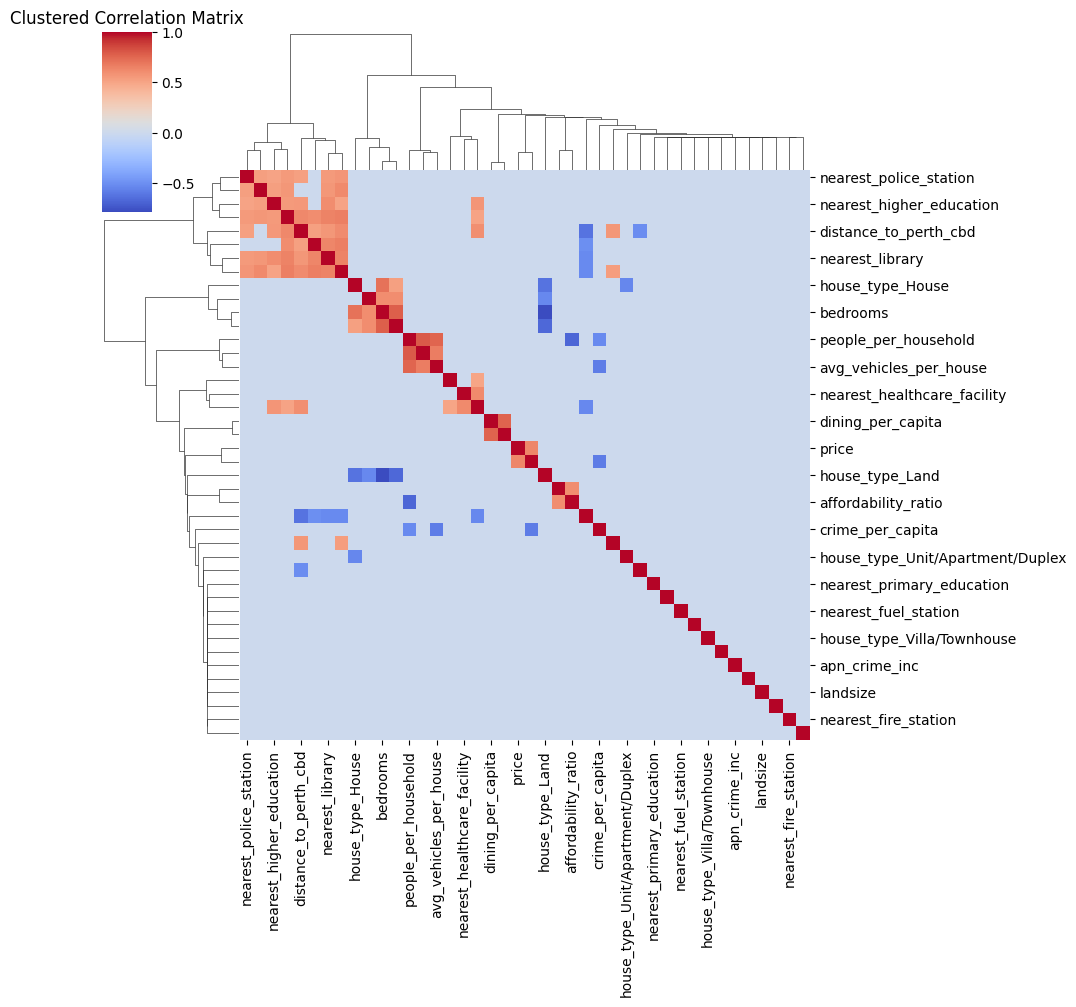

Strongest Positive Correlations (|corr| >= 0.7):
('people_per_household', 'child_per_family'): 0.79
('child_per_family', 'people_per_household'): 0.79
('bathrooms', 'bedrooms'): 0.78
('bedrooms', 'bathrooms'): 0.78
('shop_per_capita', 'dining_per_capita'): 0.77
('dining_per_capita', 'shop_per_capita'): 0.77
('avg_vehicles_per_house', 'people_per_household'): 0.76
('people_per_household', 'avg_vehicles_per_house'): 0.76
('house_type_House', 'bedrooms'): 0.71
('bedrooms', 'house_type_House'): 0.71

Strongest Negative Correlations (|corr| >= 0.7):
('house_type_Land', 'bedrooms'): -0.79
('bedrooms', 'house_type_Land'): -0.79


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Correlation matrix
corr_matrix = df[numeric_columns].corr()

# Filter to show only strong correlations (abs value > 0.5) and fill NaNs with zero
strong_corr_matrix = corr_matrix.where(corr_matrix.abs() > 0.5, other=0)

# Visualize the correlation matrix with clustering and no annotations
plt.figure(figsize=(20, 20))
sns.clustermap(strong_corr_matrix, cmap='coolwarm', annot=False, method='ward')
plt.title('Clustered Correlation Matrix')
plt.show()

# Extract and print the strongest positive and negative correlations separately
threshold = 0.7

# Extract correlations and sort by absolute value
sorted_corrs = corr_matrix.unstack().sort_values(key=abs, kind="quicksort", ascending=False)

# Filter out self-correlations
sorted_corrs = sorted_corrs[(abs(sorted_corrs) >= threshold) & (abs(sorted_corrs) < 1.0)]

# Separate positive and negative correlations
positive_corrs = sorted_corrs[sorted_corrs > 0]
negative_corrs = sorted_corrs[sorted_corrs < 0]

print("Strongest Positive Correlations (|corr| >= 0.7):")
for (index_pair, corr_value) in positive_corrs.items():
    print(f"{index_pair}: {corr_value:.2f}")

print("\nStrongest Negative Correlations (|corr| >= 0.7):")
for (index_pair, corr_value) in negative_corrs.items():
    print(f"{index_pair}: {corr_value:.2f}")



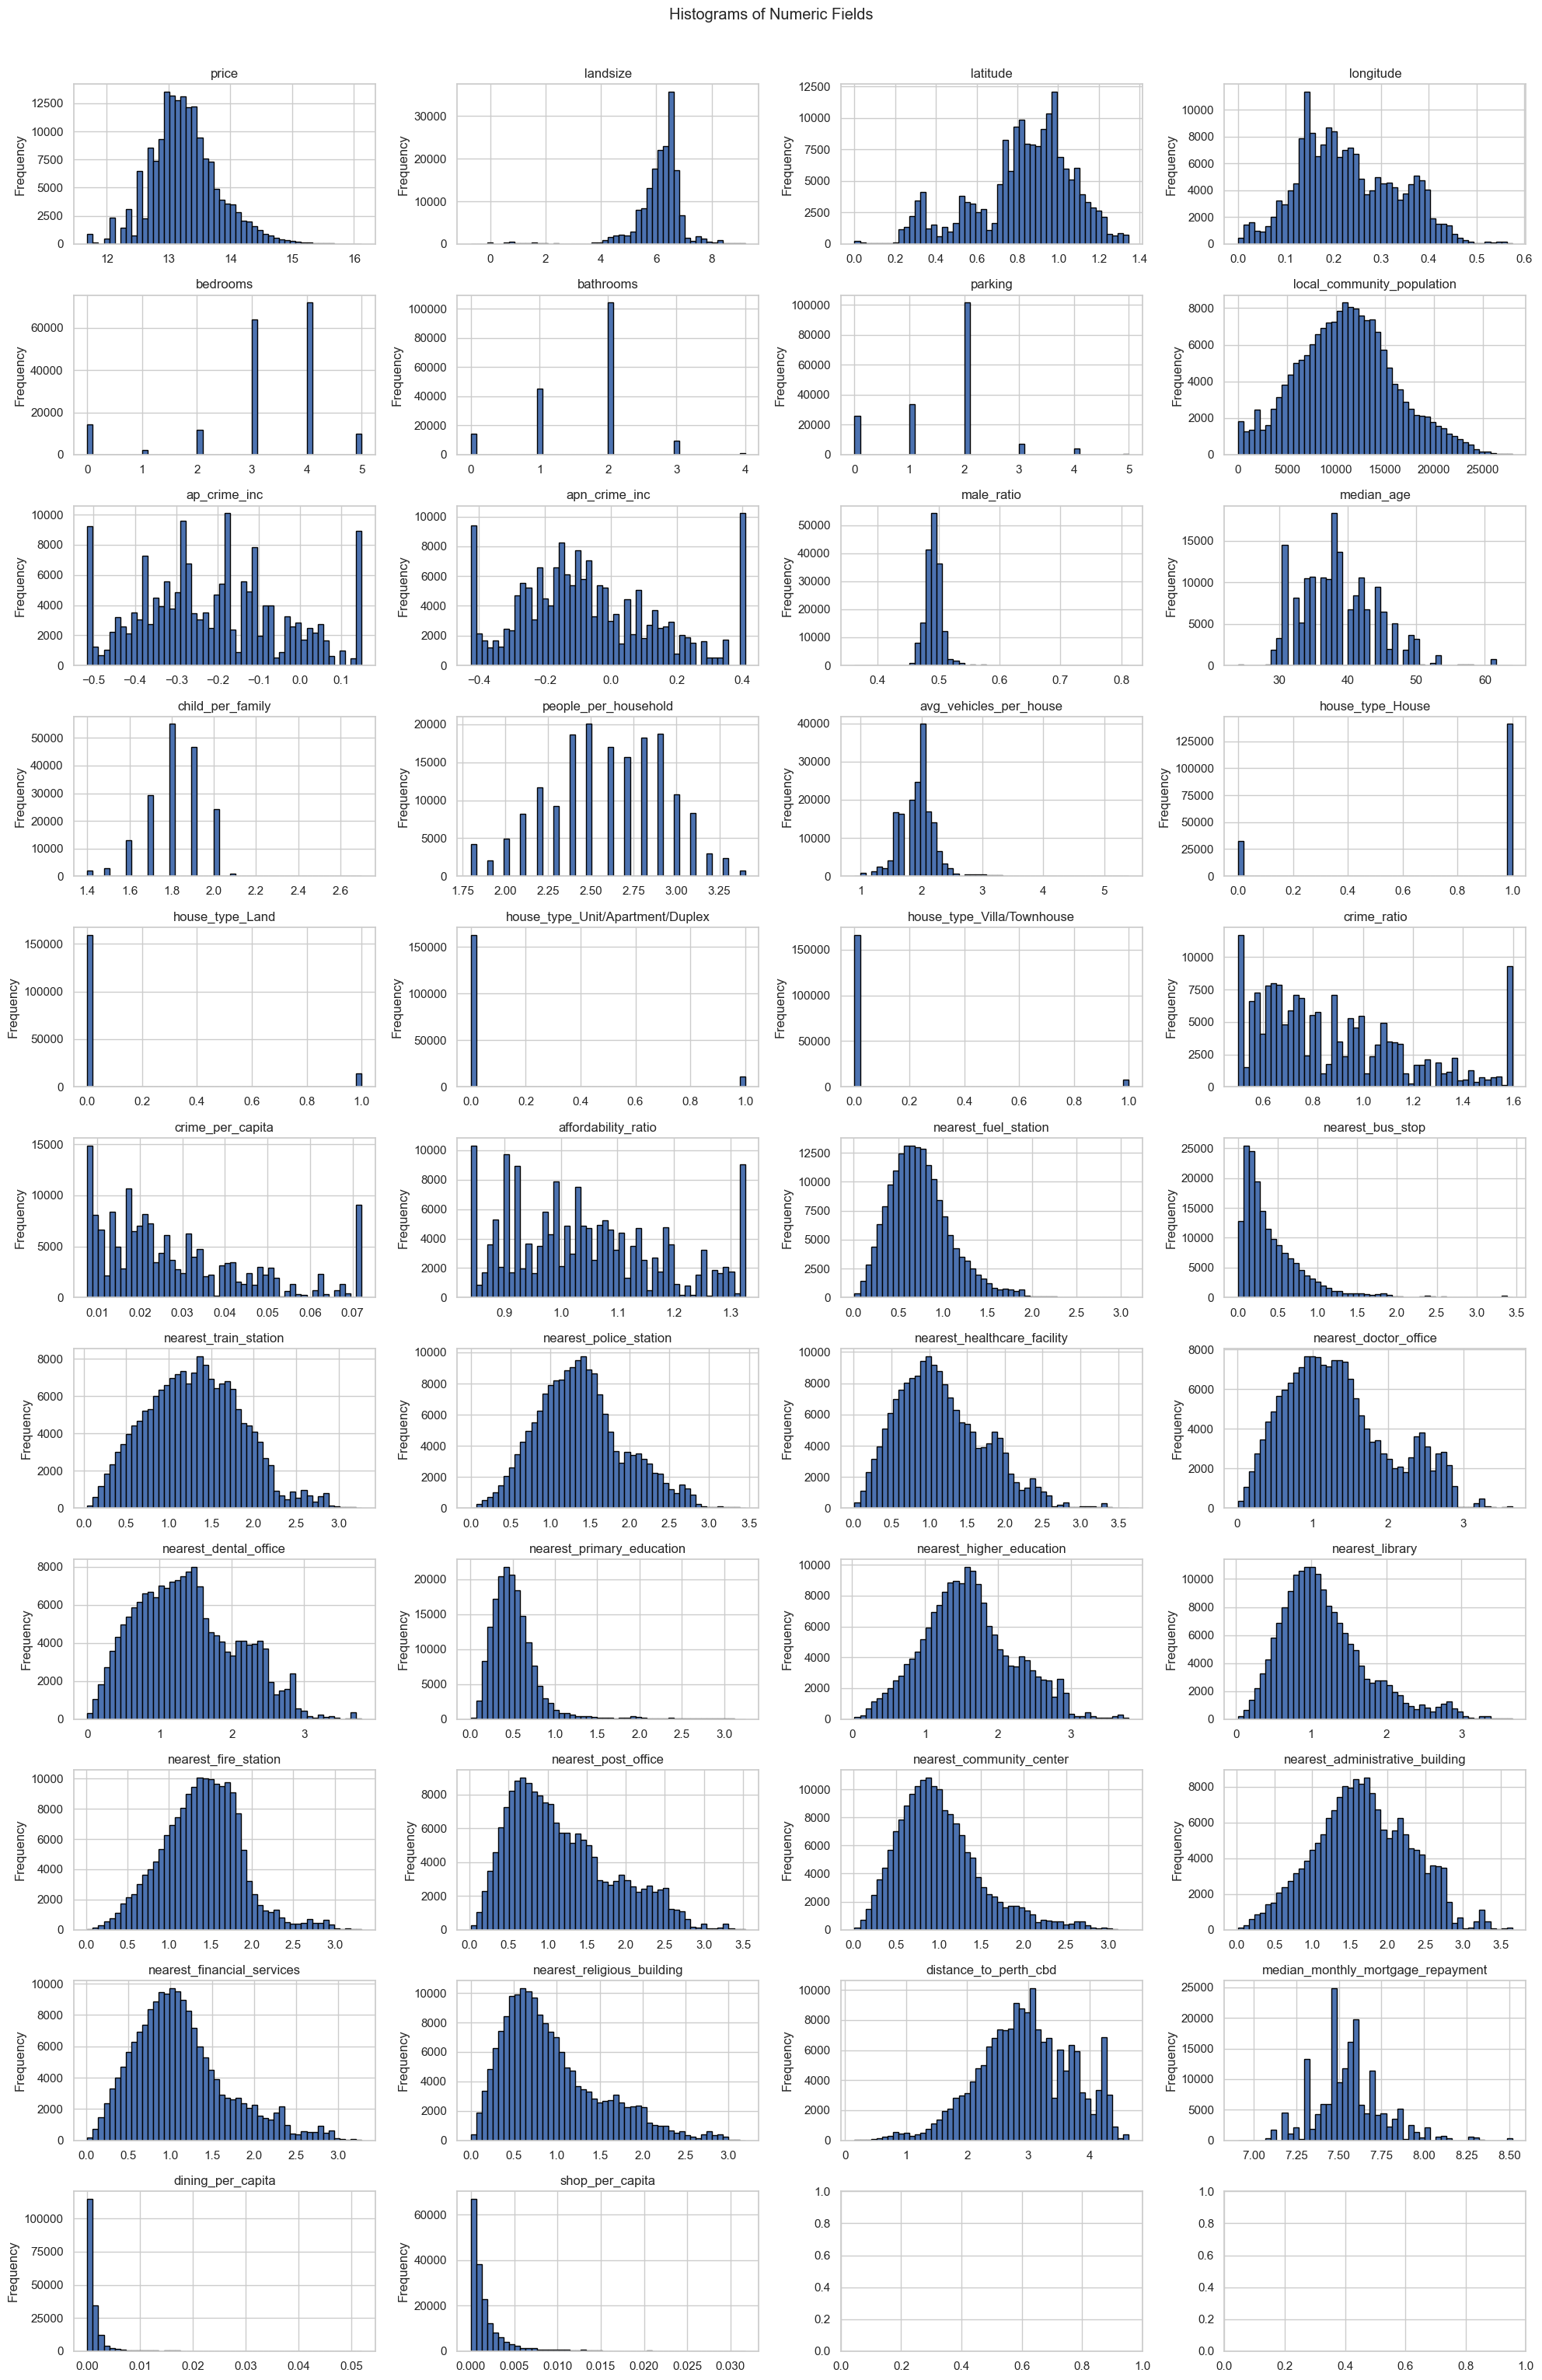

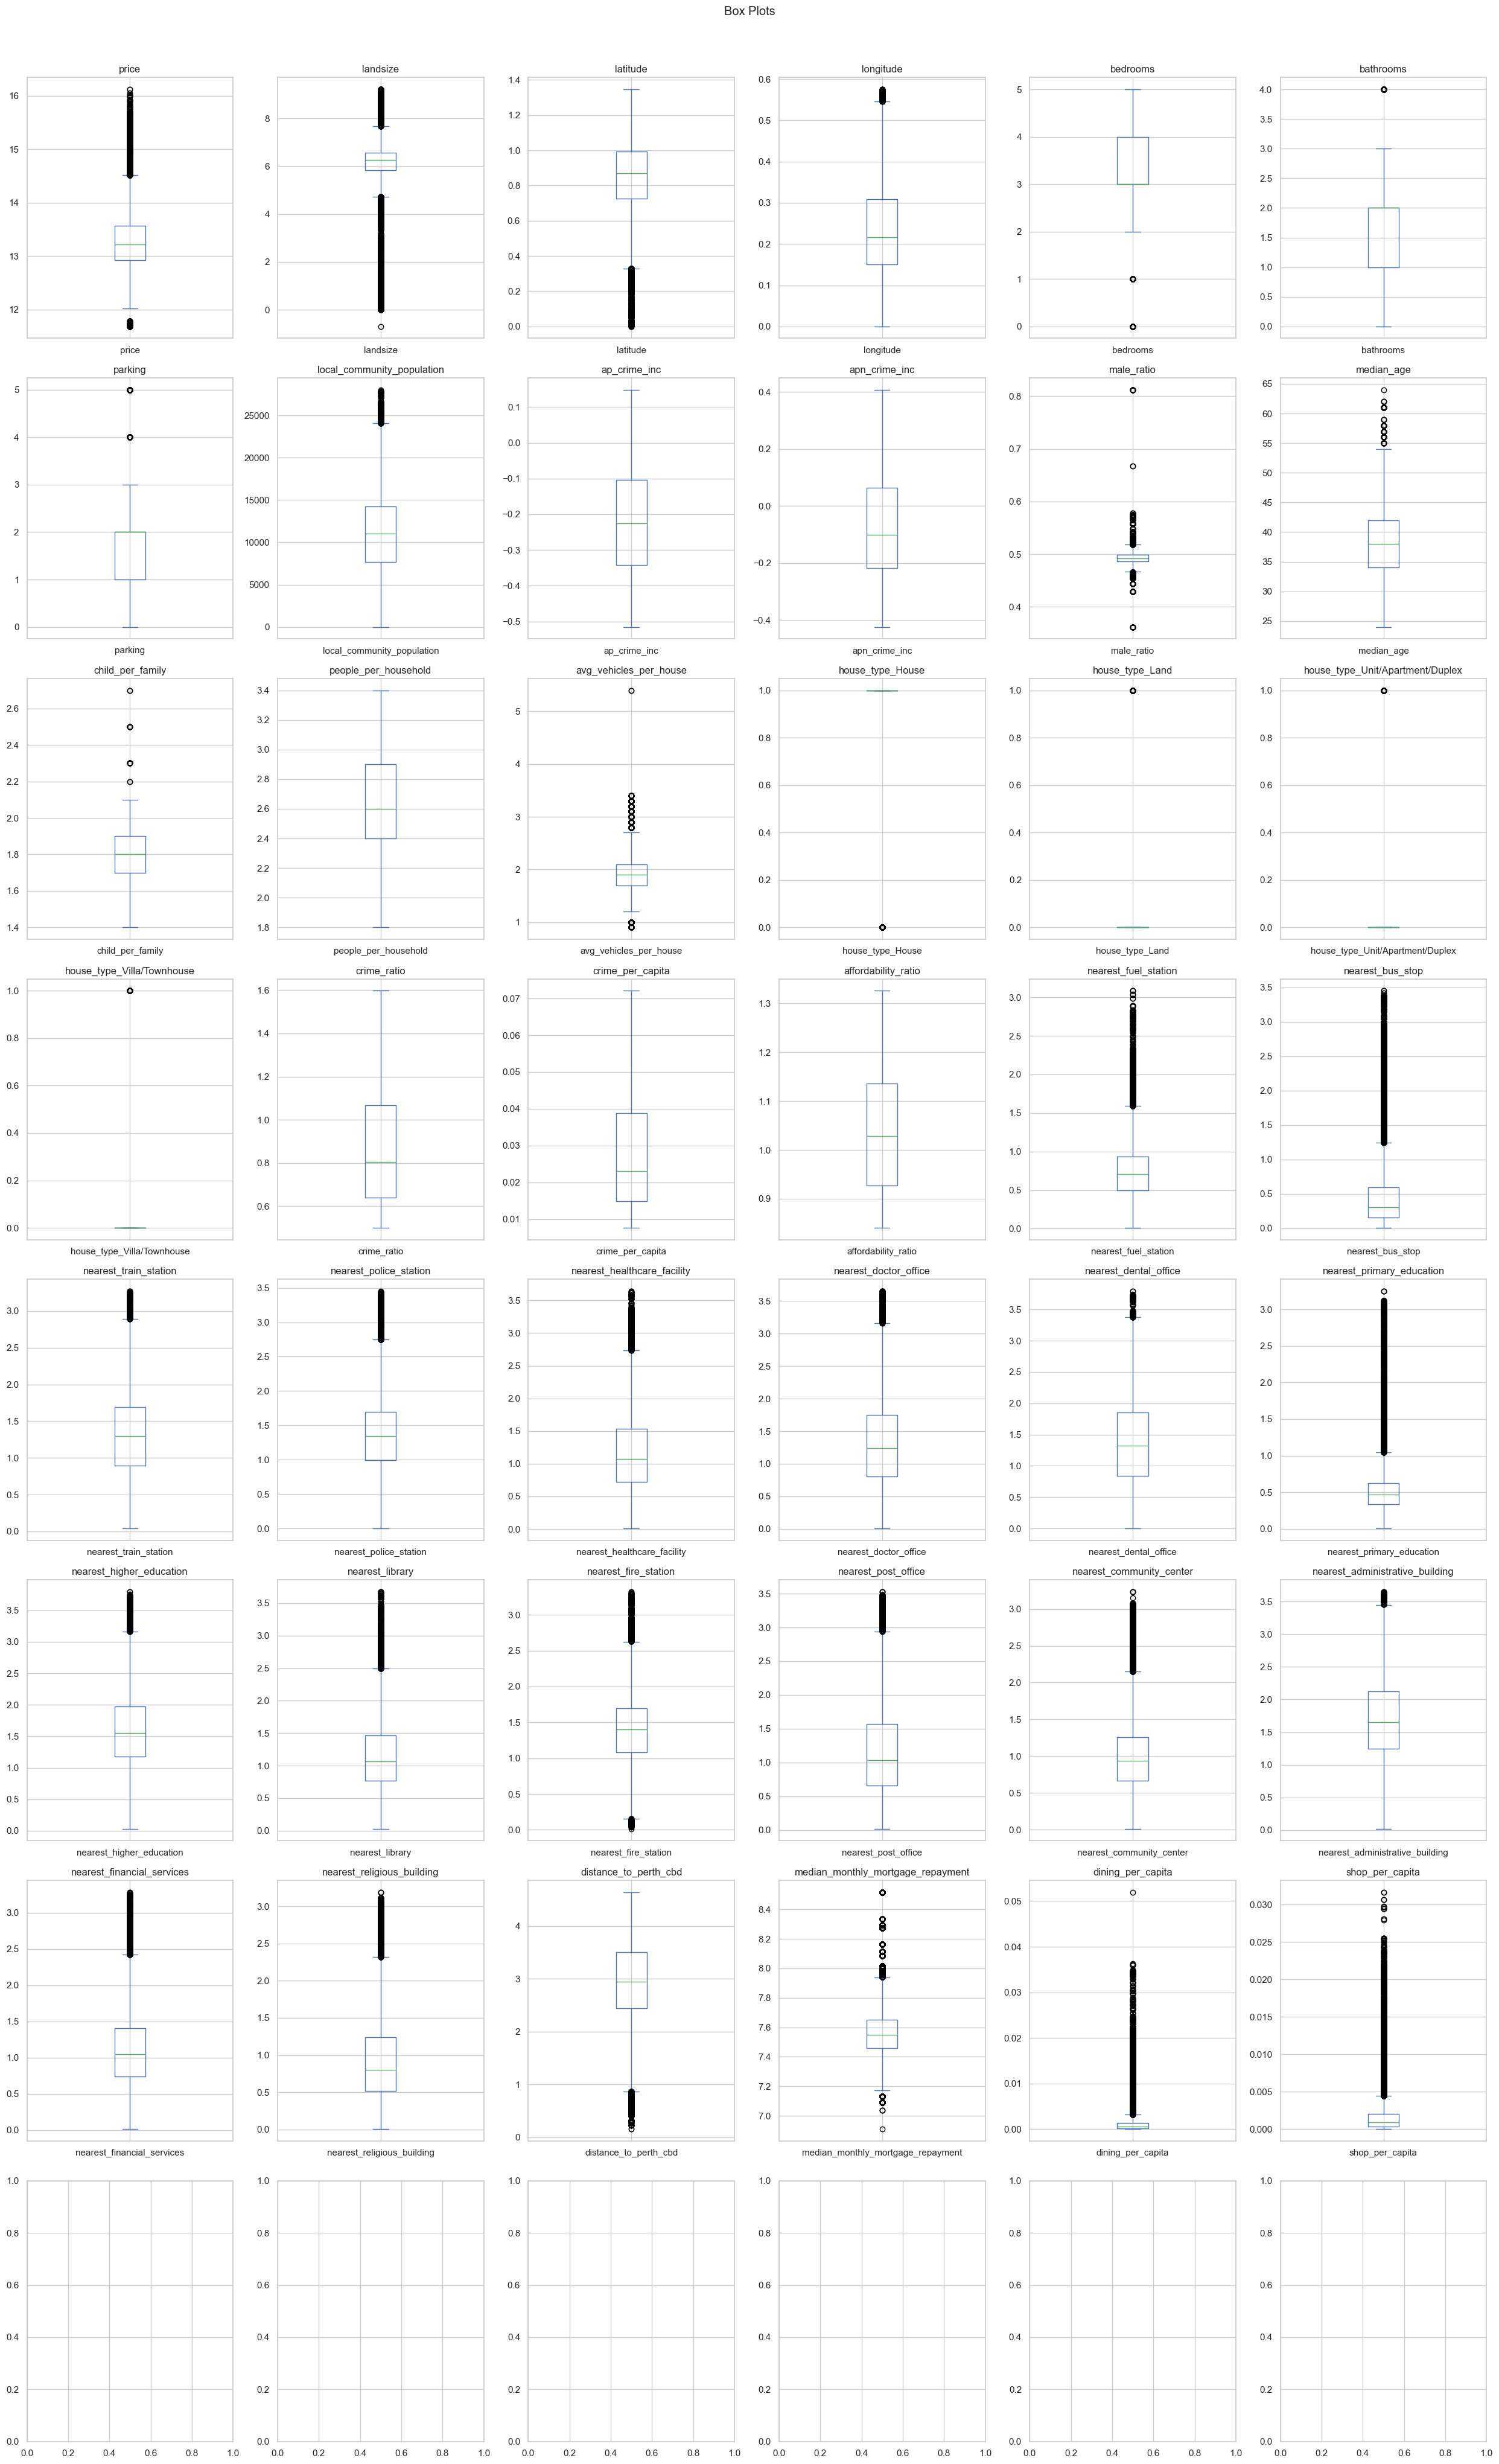

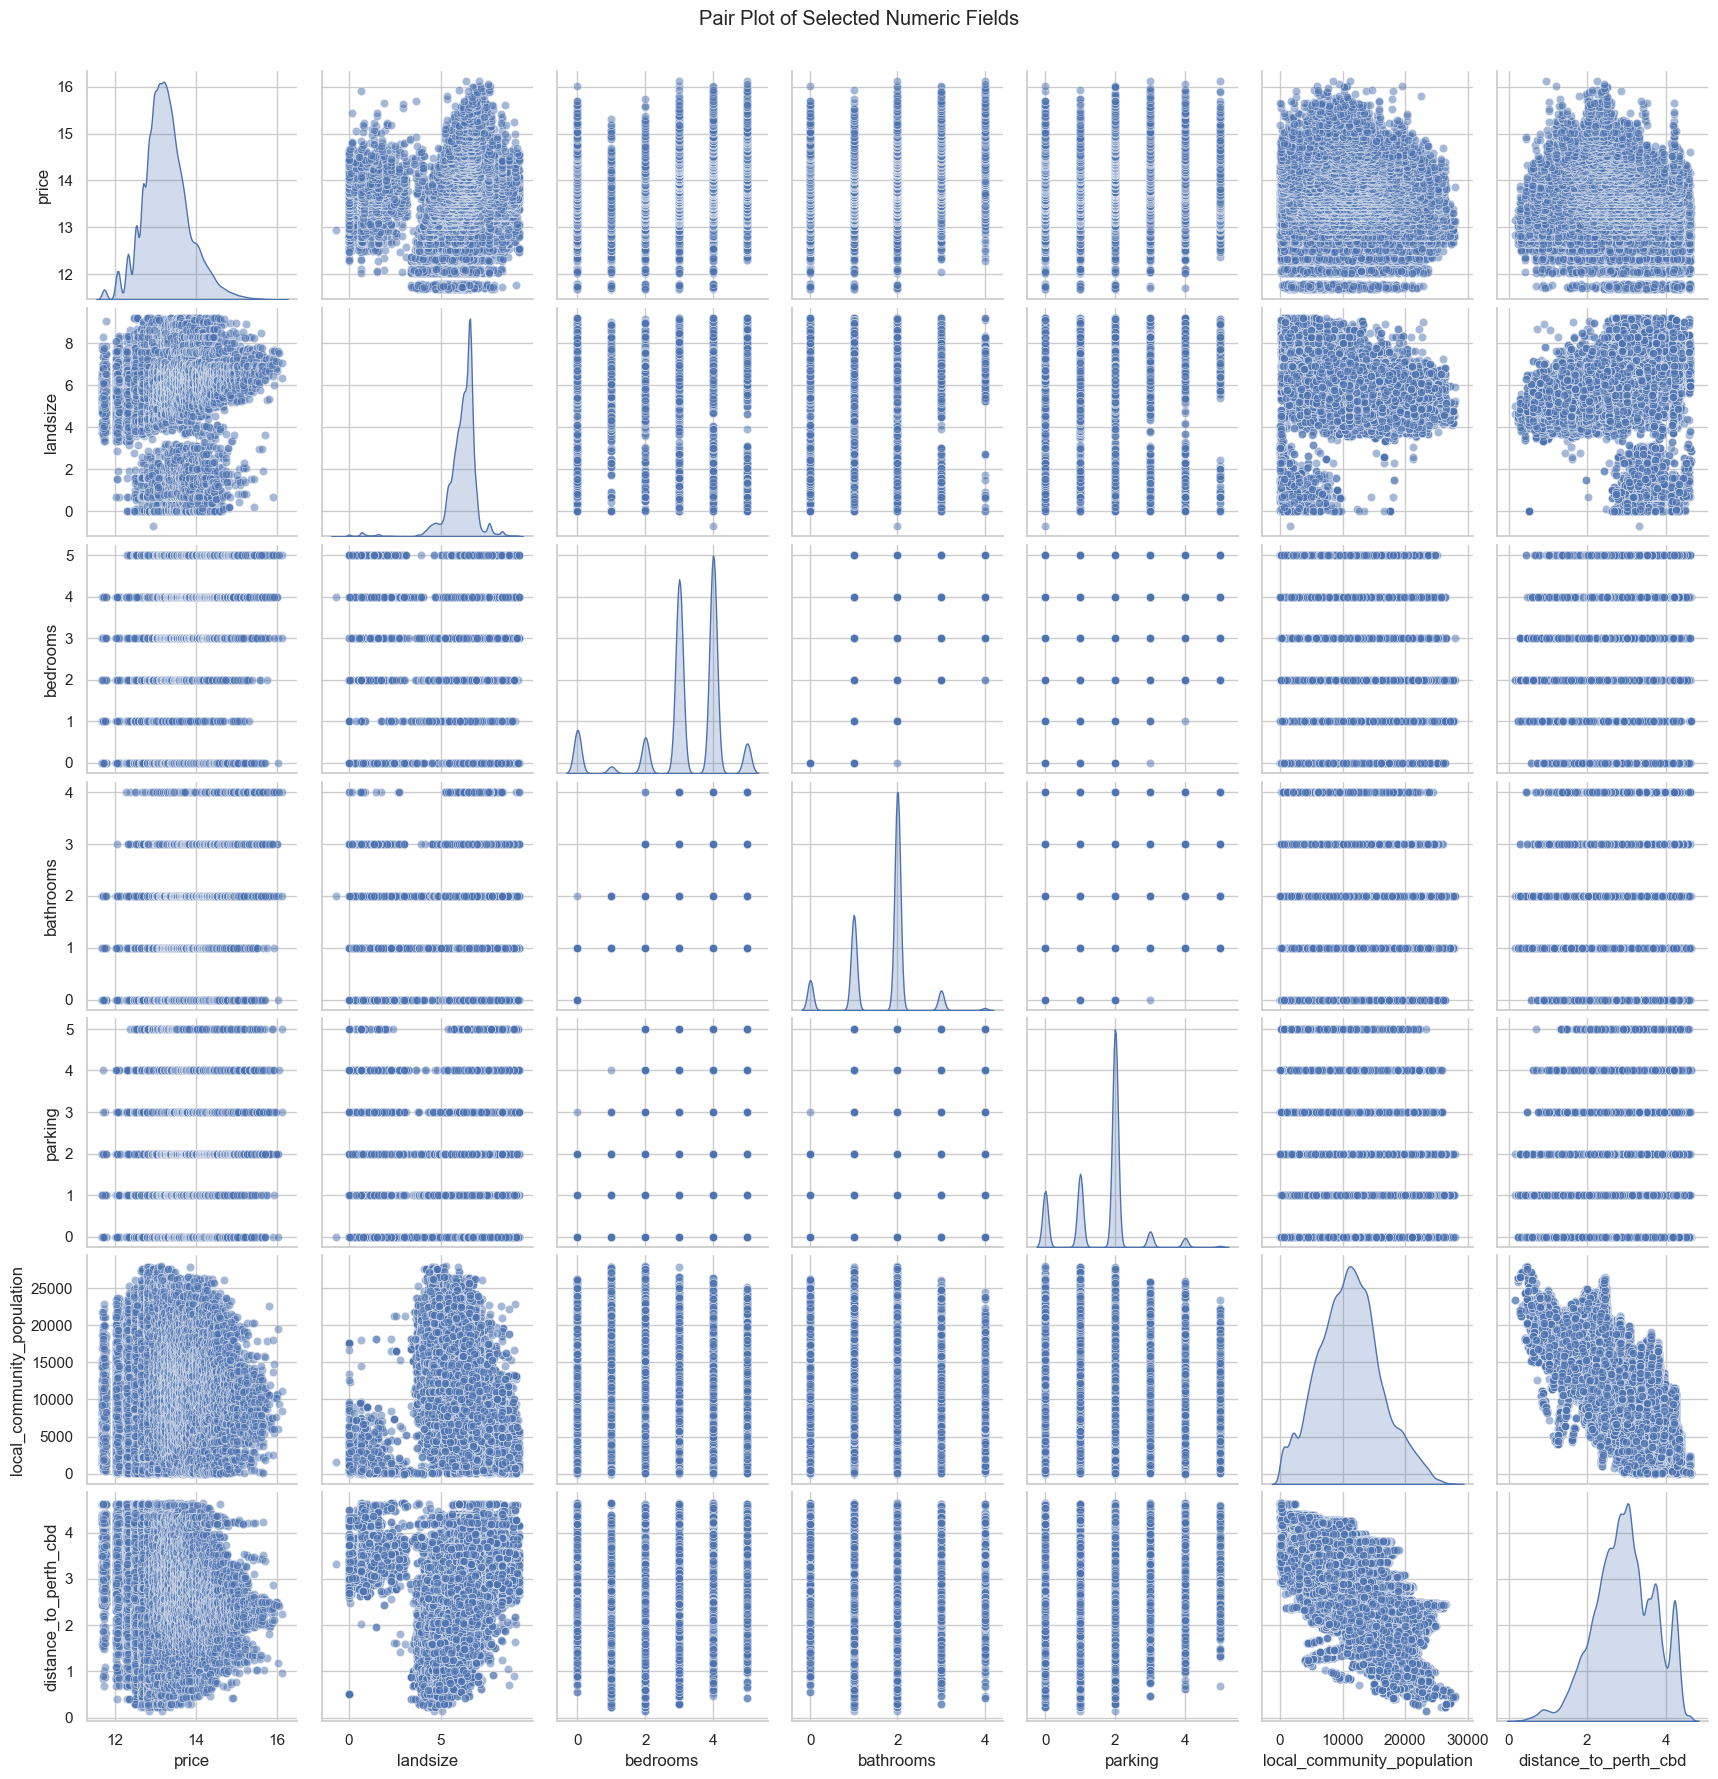

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Histograms for numeric fields
def plot_histograms(df, numeric_columns):
    fig, axes = plt.subplots(len(numeric_columns)//4 + 1, 4, figsize=(20, 30))  # Adjusted to prevent label overlap
    axes = axes.flatten()
    for idx, col in enumerate(numeric_columns):
        df[col].plot(kind='hist', bins=50, edgecolor='black', ax=axes[idx])
        axes[idx].set_title(col)
    plt.tight_layout()
    plt.suptitle('Histograms of Numeric Fields', y=1.02)
    plt.show()

# Box plots to visualize the spread and detect potential outliers
def plot_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(len(numeric_columns)//6 + 1, 6, figsize=(25, 40))  # Adjusted layout to support 72 columns
    axes = axes.flatten()
    for idx, col in enumerate(numeric_columns):
        df[col].plot(kind='box', ax=axes[idx])
        axes[idx].set_title(col)
    plt.tight_layout()
    plt.suptitle('Box Plots', y=1.02)
    plt.show()

# Pair plot for selected features to visualize pairwise relationships
def plot_pairplot(df, selected_columns):
    sns.pairplot(df[selected_columns], diag_kind='kde', plot_kws={'alpha':0.5})
    plt.suptitle('Pair Plot of Selected Numeric Fields', y=1.02)
    plt.show()

# Numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Plot histograms
plot_histograms(df, numeric_columns)

# Plot box plots
plot_boxplots(df, numeric_columns)

# Select a subset of columns for pair plot
selected_columns = ['price', 'landsize', 'bedrooms', 'bathrooms', 'parking', 'local_community_population', 'distance_to_perth_cbd']

# Plot pair plot
plot_pairplot(df, selected_columns)




In [117]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import joblib

# We only want to train on is_sold == True since we are predicting pre-sales
df_sold = df[df['is_sold'] == True]

# Split the data into features (X) and target variable (y), excluding 'identifier'
X = df_sold.drop(['price', 'is_sold', 'identifier'], axis=1)
y = df_sold['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Approach 1: XGBoost
print("Approach 1: XGBoost")

dtrain = xgb.DMatrix(X_train_scaled, label=y_train, nthread=-1)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, nthread=-1)

xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'device': 'cuda',
    'learning_rate': 0.1,
    'max_depth': 9,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1000)
xgb_predictions = xgb_model.predict(dtest)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")

# Save the scaler and the XGBoost model in JSON format
joblib.dump(scaler, 'scaler.joblib')
xgb_model.save_model('xgb_model.json')

Approach 1: XGBoost
XGBoost - MAE: 0.1536, RMSE: 0.2024


In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings

# Suppress specific FutureWarning from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.metrics._regression", lineno=483)

print("\nApproach 2: Advanced Neural Network (PyTorch)")

# Function to preprocess data
def preprocess_data(X_train, X_test):
    # Make copies of the data
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    # Ensure all columns are numeric
    X_train_copy = X_train_copy.apply(pd.to_numeric, errors='coerce')
    X_test_copy = X_test_copy.apply(pd.to_numeric, errors='coerce')

    # Handle NaN values if any were introduced by coercion
    X_train_copy = X_train_copy.fillna(0)
    X_test_copy = X_test_copy.fillna(0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_copy)
    X_test_scaled = scaler.transform(X_test_copy)

    return X_train_scaled, X_test_scaled

print("PyTorch version:", torch.__version__)

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. GPU enabled.")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

print(f"Using device: {device}")

# Define the advanced neural network model
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

# Define a function to train the model
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, num_epochs=100, batch_size=32, patience=10):
    best_loss = float('inf')
    patience_counter = 0

    # Progress bar widget and description label
    progress = widgets.IntProgress(value=0, min=0, max=num_epochs, step=1, description='Training:', bar_style='info')
    label = widgets.HTML(value=f"Epoch [0/{num_epochs}], Loss: N/A")
    display(widgets.VBox([progress, label]))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / (len(X_train_tensor) // batch_size)
        label.value = f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}"
        progress.value = epoch + 1

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            progress.bar_style = 'danger'
            label.value = f"Stopped at Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}"
            break

    # Make predictions on the test set
    model.eval()
    with torch.no_grad():
        nn_predictions = model(X_test_tensor).cpu().numpy()

    return nn_predictions

# Define the hyperparameter grid
param_grid = {
    'num_epochs': [50],
    'batch_size': [64],
    'learning_rate': [0.001]
}

best_mae = float('inf')
best_params = None
best_predictions = None

# Perform hyperparameter optimization
for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    
    # Preprocess the data for each run
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    model = AdvancedNet(X_train_tensor.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    predictions = train_model(
        model, 
        criterion, 
        optimizer, 
        X_train_tensor, 
        y_train_tensor, 
        X_test_tensor, 
        num_epochs=params['num_epochs'], 
        batch_size=params['batch_size']
    )

    # Evaluate the model
    nn_mae = mean_absolute_error(y_test, predictions)
    nn_rmse = mean_squared_error(y_test, predictions, squared=False)
    print(f"MAE: {nn_mae:.4f}, RMSE: {nn_rmse:.4f}")

    if nn_mae < best_mae:
        best_mae = nn_mae
        best_params = params
        best_predictions = predictions

print(f"Best Hyperparameters: {best_params}")
print(f"Best Neural Network - MAE: {best_mae:.4f}")

# Optionally, save the best model
torch.save(model.state_dict(), "best_model.pth")




Approach 2: Advanced Neural Network (PyTorch)
PyTorch version: 2.3.0+cu121
CUDA is available. GPU enabled.
GPU name: NVIDIA GeForce RTX 4070 Ti
Using device: cuda
Training with params: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 50}


MAE: 0.2052, RMSE: 0.2734
Best Hyperparameters: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 50}
Best Neural Network - MAE: 0.2052


In [95]:
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
import joblib
import numpy as np
import json

# Filter out the unsold data
df_unsold = df[df['is_sold'] == False].copy()  # Create a copy to avoid the warning

# Retain the identifier column for later use
unsold_identifiers = df_unsold[['identifier']]

# Prepare the features for prediction, excluding unnecessary columns
X_unsold = df_unsold.drop(['price', 'is_sold', 'identifier'], axis=1)

# Load the scaler and apply it to the unsold data
scaler = joblib.load('scaler.joblib')
X_unsold_scaled = scaler.transform(X_unsold)

# Load the XGBoost model
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model.json')
dunsold = xgb.DMatrix(X_unsold_scaled)
xgb_predictions = xgb_model.predict(dunsold)

# Define the advanced neural network model (same architecture as trained model)
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

# Load the ANN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_unsold_scaled.shape[1]
ann_model = AdvancedNet(input_dim).to(device)
ann_model.load_state_dict(torch.load('best_model.pth'))
ann_model.eval()

# Convert the scaled features to a tensor
features_tensor = torch.tensor(X_unsold_scaled, dtype=torch.float32).to(device)

# Make predictions with the ANN model
with torch.no_grad():
    ann_predictions = ann_model(features_tensor).cpu().numpy()

# Add individual predictions to the unsold data
df_unsold['xgb_predictions'] = xgb_predictions
df_unsold['ann_predictions'] = ann_predictions

# Combine the predictions by averaging them
df_unsold['ensemble_predictions'] = (df_unsold['xgb_predictions'] + df_unsold['ann_predictions']) / 2

# Un-log the predicted prices (apply inverse of log transformation)
df_unsold['xgb_predictions'] = np.exp(df_unsold['xgb_predictions'])
df_unsold['ann_predictions'] = np.exp(df_unsold['ann_predictions'])
df_unsold['ensemble_predictions'] = np.exp(df_unsold['ensemble_predictions'])

# Add predictions to the unsold data using .loc to avoid the warning
df_unsold.loc[:, 'predicted_price'] = df_unsold['ensemble_predictions']

In [97]:
import pandas as pd
import numpy as np
import json

# Merge the predictions with df_target
df_target_pred = pd.merge(df_target, df_unsold[['identifier', 'xgb_predictions', 'ann_predictions', 'ensemble_predictions']], on='identifier', how='left')

# Reorder columns to place xgb_predictions, ann_predictions, and ensemble_predictions as the third, fourth, and fifth columns
cols = list(df_target_pred.columns)
xgb_index = cols.index('xgb_predictions')
ann_index = cols.index('ann_predictions')
ensemble_index = cols.index('ensemble_predictions')

# Move xgb_predictions, ann_predictions, and ensemble_predictions to the front after the first two columns
cols.insert(2, cols.pop(xgb_index))
cols.insert(3, cols.pop(ann_index))
cols.insert(4, cols.pop(ensemble_index))

df_target_pred = df_target_pred[cols]

# Remove rows with no predicted price
rows_before = df_target_pred.shape[0]
df_target_cleaned = df_target_pred.dropna(subset=['ensemble_predictions'])
rows_after = df_target_cleaned.shape[0]

# Print the number of rows removed
rows_removed = rows_before - rows_after
print(f"Number of rows removed: {rows_removed}")

# Save the cleaned DataFrame to a CSV file
df_target_cleaned.to_csv('property_data_unsold_predictions.csv', index=False)

# Convert the cleaned DataFrame to JSON format
df_target_cleaned_json = df_target_cleaned.to_dict(orient='records')

# Save the JSON to a file
with open('property_data_unsold_predictions.json', 'w') as json_file:
    json.dump(df_target_cleaned_json, json_file, indent=4)

# Display a few entries from the JSON file
df_target_cleaned_json[:5]


Number of rows removed: 400


[{'address': '5/1149 Old Coast Road, Dawesville',
  'price': 125000,
  'xgb_predictions': 126671.0234375,
  'ann_predictions': 204427.40625,
  'ensemble_predictions': 160919.40625,
  'landsize': 139.0,
  'latitude': -32.6359313,
  'longitude': 115.6397769,
  'bedrooms': 1,
  'bathrooms': 1,
  'parking': 0,
  'house_type': 'Unit',
  'image_url': 'https://imagecdn.reiwa.com.au/listing/60/4802360-01.jpg?maxwidth=800&maxheight=600&quality=80',
  'details_url': '/5-1149-old-coast-road-dawesville-4802360/',
  'is_sold': False,
  'suburb': 'Dawesville',
  'local_community_population': 4428,
  'local_community_dwellings': 2006,
  'distance_to_perth_cbd': 78.92290631231367,
  'distance_to_perth_airport': 83.43510520997272,
  'nearest_fuel_station': 0.9148762234486837,
  'nearest_bus_stop': 0.13614865395729717,
  'nearest_train_station': 15.710154472128306,
  'nearest_police_station': 14.560863214828064,
  'nearest_healthcare_facility': 9.587335742581256,
  'nearest_doctor_office': 0.20337929742

In [98]:
# Evaulate ensemble prediction value

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming X_test_scaled is the scaled test dataset
dtest = xgb.DMatrix(X_test_scaled)

# XGBoost predictions on the test set
xgb_test_predictions = xgb_model.predict(dtest)

# ANN predictions on the test set
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    ann_test_predictions = ann_model(X_test_tensor).cpu().numpy()

# Combine predictions (ensemble)
ensemble_test_predictions = (xgb_test_predictions + ann_test_predictions.flatten()) / 2

# Un-log predictions if necessary
xgb_test_predictions = np.exp(xgb_test_predictions)
ann_test_predictions = np.exp(ann_test_predictions)
ensemble_test_predictions = np.exp(ensemble_test_predictions)

# True values for the test set
y_test_true = np.exp(y_test)  # Assuming y_test is in log scale

# Evaluate XGBoost
xgb_mae = mean_absolute_error(y_test_true, xgb_test_predictions)
xgb_rmse = mean_squared_error(y_test_true, xgb_test_predictions, squared=False)
print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")

# Evaluate ANN
ann_mae = mean_absolute_error(y_test_true, ann_test_predictions)
ann_rmse = mean_squared_error(y_test_true, ann_test_predictions, squared=False)
print(f"ANN - MAE: {ann_mae:.4f}, RMSE: {ann_rmse:.4f}")

# Evaluate Ensemble
ensemble_mae = mean_absolute_error(y_test_true, ensemble_test_predictions)
ensemble_rmse = mean_squared_error(y_test_true, ensemble_test_predictions, squared=False)
print(f"Ensemble - MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")

XGBoost - MAE: 105920.2154, RMSE: 189759.9162
ANN - MAE: 155613.6386, RMSE: 324281.1377
Ensemble - MAE: 123393.7154, RMSE: 246796.6281
